# Convolutional Neural Networks

Let's look at CNNs, and how we can do simple classification with them.

## Data

We'll use a subset of the wine reviews

In [2]:
import pandas as pd

target = 'country'
input_column = 'description_cleaned'

data = pd.read_excel('../data/wine_reviews-top4.xlsx', 
                     usecols=[input_column, target]
                    )

# make train-dev-test splits
train_data = data[:45000]
dev_data = data[45000:60000]
test_data = data[60000:]

train_instances = train_data[input_column].apply(str).apply(str.split)
train_labels = train_data[target]

# collect known word tokens and tags
wordset, labelset = set(), set()

# collect tags from all data, to prevent unseen labels
labelset.update(set(data[target]))

# get the vocabulary
for words in train_instances:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
label2int = {label: i for i, label in enumerate(sorted(labelset))}
# inverted index to translate it back
int2label = {i:label for label, i in label2int.items()}


def convert2ints(instances):
    """
    function to apply the mapping to all words
    """
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        result.append(word_ints)
    return result
                          
train_instances_int = convert2ints(train_instances)
train_labels_int = [label2int[label] for label in train_labels]

In [3]:
data

,country,description_cleaned
0,US,wine drink qualitatively its low price deliver...
1,US,soft creamy flavor buttered toast pineapple ma...
2,US,bit too soft which make exceptionally ripe bla...
3,US,dark purple mixed aroma juicy plum sawdust clo...
4,Italy,deliver very attractive ensemble ripe fruit ar...
...,...,...
75264,US,ripe cherry chocolate fruit slightly rustic mo...
75265,Italy,make use organically farm fruit be simple frui...
75266,Italy,show pretty polished nose dusty mineral note b...
75267,France,be not just late harvest wine there be definit...


Let's see how many words we have in our vocabulary:

In [3]:
len(word2int)

12115

Ok, time to convert the dev and test splits as well:

In [4]:
# convert test data 
test_instances = test_data[input_column].apply(str).apply(str.split)
test_labels = test_data[target]

test_instances_int = convert2ints(test_instances)
test_labels_int = [label2int[label] for label in test_labels]

# convert dev data
dev_instances = dev_data[input_column].apply(str).apply(str.split)
dev_labels = dev_data[target]

dev_instances_int = convert2ints(dev_instances)
dev_labels_int = [label2int[label] for label in dev_labels]

We need to convert the labels from a single value to a 1-hot distribution over all possible values (i.e., all have 0 probabilty, only the correct label has probability 1). Luckily, there is a function for it.

In [5]:
from keras.utils import to_categorical

train_labels_1hot = to_categorical(train_labels_int, len(label2int))
test_labels_1hot = to_categorical(test_labels_int, len(label2int))
dev_labels_1hot = to_categorical(dev_labels_int, len(label2int))

train_labels_1hot[0]

array([0., 0., 0., 1.], dtype=float32)

Even though CNNs can take variable-length input, it is easier computationally to pad all instances up to the same length. We could just use the maximum length, but since length follows a power law (Zipf) distribution, we would pad a lot of instances to match only the real length of one or two very long sequences. Instead, we use the 95th percentile of length as maximum.

In [6]:
# compute 95th percentile of training sentence lengths
L = sorted(map(len, train_instances))
MAX_LENGTH = L[int(len(L)*0.95)]
print(MAX_LENGTH)

# apply padding
from keras.preprocessing.sequence import pad_sequences
train_instances_int = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH)
test_instances_int = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH)
dev_instances_int = pad_sequences(dev_instances_int, padding='post', maxlen=MAX_LENGTH)

print(train_instances[0], len(train_instances[0]))
print(train_instances_int[0], len(train_instances_int[0]))

39
['wine', 'drink', 'qualitatively', 'its', 'low', 'price', 'deliver', 'light', 'clear', 'color', 'tangy', 'wisps', 'cranberry', 'citrus', 'ting', 'minerality', 'depth', 'character', 'that', 'build', 'midpalate', 'finish', 'lean', 'crisp', 'wonderfully', 'elegant', 'expression', 'variety'] 28
[11900  3284  8306  5597  6123  8071  2917  5964  2019  2157 10570 11931
  2570  1971 10843  6543  2955  1787 10739  1445  6498  4066  5871  2621
 11954  3455  3816 11542     0     0     0     0     0     0     0     0
     0     0     0] 39


## Model

Ok, let's implement the model. We will use the functional API for keras to do that. I.e., each layer is a function that takes as input the previous layer.

In [8]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation
import numpy as np

# make it repeatable
np.random.seed(42)

# set parameters of matrices and convolution
embedding_dim = 64
nb_filter = 64
filter_length = 3
hidden_dims = 32
stride_length = 1

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs)
convolution = Conv1D(filters=nb_filter,  # Number of filters to use
                    kernel_size=filter_length, # n-gram range of each filter.
                    padding='same',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=stride_length)(embeddings)
convolution2 = Activation(activation='tanh')(convolution)
pooling = GlobalMaxPooling1D()(convolution2)
dropout1 = Dropout(0.2)(pooling)
dense = Dense(hidden_dims, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(len(label2int), activation='softmax')(dropout2)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# get alist of all the layers and their size
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 39)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 39, 64)            775360    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 64)            12352     
_________________________________________________________________
activation_1 (Activation)    (None, 39, 64)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080

We easily have twice the parameters we had for the structured perceptron already, and way more than what we would ordinarily have for classification models. 

Let's fit the data. One of the most important parameters is the batch size. If things do not work, this is one of the first to play around with.

In [9]:
# batch size can have a huge effect on performance!
batch_size = 64
epochs = 5

history = model.fit(train_instances_int, train_labels_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(dev_instances_int, dev_labels_1hot)
                   )

loss, accuracy = model.evaluate(test_instances_int, test_labels_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/5
704/704 [==============================] - 6s 8ms/step - loss: 0.8262 - accuracy: 0.6842 - val_loss: 0.2787 - val_accuracy: 0.9079
Epoch 2/5
704/704 [==============================] - 6s 8ms/step - loss: 0.2715 - accuracy: 0.9115 - val_loss: 0.2365 - val_accuracy: 0.9213
Epoch 3/5
704/704 [==============================] - 6s 8ms/step - loss: 0.1694 - accuracy: 0.9476 - val_loss: 0.2367 - val_accuracy: 0.9243
Epoch 4/5
704/704 [==============================] - 5s 8ms/step - loss: 0.1162 - accuracy: 0.9633 - val_loss: 0.2418 - val_accuracy: 0.9227
Epoch 5/5
704/704 [==============================] - 5s 8ms/step - loss: 0.0823 - accuracy: 0.9733 - val_loss: 0.2787 - val_accuracy: 0.9225

Testing Accuracy:  0.9207


The `history`property allows us to easily plot the progression of the model on training and test data. By default, it measures accuracy (meh) and loss. Note that the loss is not necessarily the best indicator of performance, though it does correlate with most metrics we're interested in.

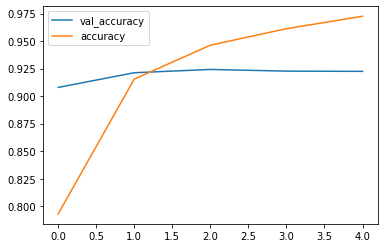

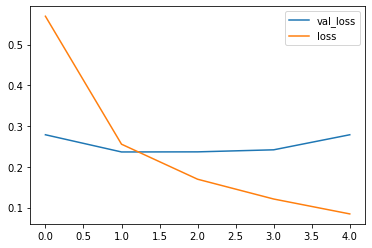

In [10]:
%matplotlib inline
df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

# Structured  Prediction with (Bi-)LSTMs

Let's now look at structured prediction. We will use two recurrent neural models: an LSTM and a bi-LSTM.

## Data

We need to get some data. We use the same CoNLL reader function as we had for the Structured Perceptron.

In [9]:
def read_conll_file(file_name):
    """
    read in a file with CoNLL format:
    word1    tag1
    word2    tag2
    ...      ...
    wordN    tagN

    Sentences MUST be separated by newlines!
    """
    current_words = []
    current_tags = []

    with open(file_name, encoding='utf-8') as conll:
        for line in conll:
            line = line.strip()

            if line:
                word, tag = line.split('\t')
                current_words.append(word)
                current_tags.append(tag)

            else:
                yield (current_words, current_tags)
                current_words = []
                current_tags = []

    # if file does not end in newline (it should...), check whether there is an instance in the buffer
    if current_tags != []:
        yield (current_words, current_tags)

Now we need to do some bookkeeping: collect the set of known words and tags, map both words and tags into integer indices, and keep track of the mapping. We also need two special tokens: one for unknown words, the other one for padding.

In [10]:
# collect known word tokens and tags
wordset, tagset = set(), set()
train_instances = [(words, tags) for (words, tags) in read_conll_file('../data/tiny_POS_train.data')]
for (words, tags) in train_instances:
    tagset.update(set(tags))
    wordset.update(set(words))
 
# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0
# to translate it back
int2tag = {i:tag for tag, i in tag2int.items()}


def convert2ints(instances):
    result = []
    for (words, tags) in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result        

Again, let's convert all our data first.

In [11]:
# get some test data
test_instances = [(words, tags) for (words, tags) in read_conll_file('../data/tiny_POS_test.data')]

# apply integer mapping
train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

# separate the words from the tags
train_sentences, train_tags = zip(*train_instances_int) 
test_sentences, test_tags = zip(*test_instances_int) 

print(train_instances[0][0])
print(train_sentences[0])
print(train_instances[0][1])
print(train_tags[0])

['Showtime', 'is', 'a', 'distant', 'No.', '0', 'to', 'Home', 'Box', 'Office', ',', 'and', 'in', 'May', 'filed', 'a', '$', '0.0', 'billion', 'antitrust', 'suit', 'against', 'Time', 'Warner', ',', 'charging', 'the', 'company', 'and', 'its', 'HBO', 'and', 'American', 'Television', 'cable', 'units', 'with', 'conspiring', 'to', 'monopolize', 'the', 'pay', 'TV', 'business', '.']
[1789, 4586, 2131, 3496, 1433, 25, 6898, 929, 331, 1472, 20, 2336, 4422, 1282, 3917, 2131, 3, 31, 2627, 2357, 6697, 2255, 1949, 2054, 20, 2878, 6829, 3000, 2336, 4594, 875, 2336, 175, 1917, 2780, 7069, 7309, 3104, 6898, 5051, 6829, 5413, 1899, 2755, 23]
['NOUN', 'VERB', 'DET', 'ADJ', 'NOUN', 'NUM', 'ADP', 'NOUN', 'NOUN', 'NOUN', '.', 'CONJ', 'ADP', 'NOUN', 'VERB', 'DET', '.', 'NUM', 'NUM', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.', 'VERB', 'DET', 'NOUN', 'CONJ', 'PRON', 'NOUN', 'CONJ', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'VERB', 'PRT', 'VERB', 'DET', 'NOUN', 'NOUN', 'NOUN', '.']
[7, 11, 6, 2, 7, 8, 3, 7, 7, 7, 1, 

Even though RNNs theoretically work for any length input, in practice, we need to make every sentence the same length. We choose the longest training sentence, add some extra, and then pad everything up to that length.

In [12]:
# get longest training sentence and add 5
MAX_LENGTH = len(max(train_sentences, key=len)) + 5
print(MAX_LENGTH)


87


`Keras` provides a function to do the padding for us:

In [13]:
from keras.preprocessing.sequence import pad_sequences
 
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences[0])
print(train_tags[0])

[1789 4586 2131 3496 1433   25 6898  929  331 1472   20 2336 4422 1282
 3917 2131    3   31 2627 2357 6697 2255 1949 2054   20 2878 6829 3000
 2336 4594  875 2336  175 1917 2780 7069 7309 3104 6898 5051 6829 5413
 1899 2755   23    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
[ 7 11  6  2  7  8  3  7  7  7  1  5  3  7 11  6  1  8  8  2  7  3  7  7
  1 11  6  7  5  9  7  5  7  7  7  7  3 11 10 11  6  7  7  7  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## Model

We use the [functional API](https://keras.io/getting-started/functional-api-guide/) in `keras`. Each layer is a function, which takes as input the previous layer.

In [14]:
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
lstm = LSTM(units=256,
              return_sequences=True,
              name="LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(lstm)
lstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(lstm_out)

model = Model(inputs=[inputs], outputs=[output])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 87)]              0         
_________________________________________________________________
embeddings (Embedding)       (None, 87, 128)           945408    
_________________________________________________________________
LSTM (LSTM)                  (None, 87, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 87, 256)           0         
_________________________________________________________________
output (Dense)               (None, 87, 13)            3341      
_________________________________________________________________
softmax (Activation)         (None, 87, 13)            0         
Total params: 1,342,989
Trainable params: 1,342,989
Non-trainable params: 0
_________________________________________________

In order to read the tags, the model needs 1-hot encoding, i.e., a vector with one dimension for each tag, all of them 0, except the one dimension corresponding to the tag we have. Lucikly, there exists a utility function for it.

In [15]:
from keras.utils import to_categorical

train_tags_1hot = to_categorical(train_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))

# originally 50 tag IDs
print(train_tags[0])
# now 50 rows with 13 columns
print(train_tags_1hot[0].shape)
# the 1-hot encoding of tag ID 7
print(train_tags_1hot[0])

[ 7 11  6  2  7  8  3  7  7  7  1  5  3  7 11  6  1  8  8  2  7  3  7  7
  1 11  6  7  5  9  7  5  7  7  7  7  3 11 10 11  6  7  7  7  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(87, 13)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Now we can train the model

In [16]:
batch_size = 16
epochs = 5

# compile the model we have defined above
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/5
101/101 [==============================] - 31s 272ms/step - loss: 0.5829 - accuracy: 0.3257 - val_loss: 0.2447 - val_accuracy: 0.7486
Epoch 2/5
101/101 [==============================] - 23s 223ms/step - loss: 0.1670 - accuracy: 0.8156 - val_loss: 0.0953 - val_accuracy: 0.9055
Epoch 3/5
101/101 [==============================] - 25s 243ms/step - loss: 0.0494 - accuracy: 0.9522 - val_loss: 0.0738 - val_accuracy: 0.9253
Epoch 4/5
101/101 [==============================] - 25s 247ms/step - loss: 0.0282 - accuracy: 0.9701 - val_loss: 0.0724 - val_accuracy: 0.9206
Epoch 5/5
101/101 [==============================] - 26s 258ms/step - loss: 0.0194 - accuracy: 0.9797 - val_loss: 0.0703 - val_accuracy: 0.9293


We can plot the performance on training and dev set

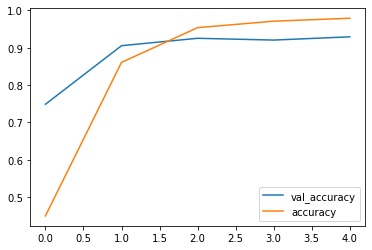

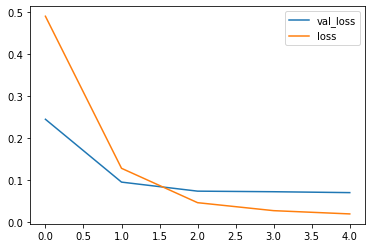

In [17]:
%matplotlib inline
import pandas as pd
import seaborn

df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

Let's see how well we do on the test set

In [18]:
loss, accuracy = model.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

13/13 [==============================] - 1s 41ms/step - loss: 0.0951 - accuracy: 0.9050
Test loss: 0.09511490911245346
Test accuracy: 0.9049999713897705


Not too bad! Let's see how well it does with sentences that have ambiguous words:

In [19]:
strange_sentences = ['Their management plan reforms worked'.split(),
                     "Attack was their best option".split()
                    ]
# convert to integers
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
# add padding
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(strange_sentences_int)
print(predictions, predictions.shape)

[[[3.4372021e-02 7.0667895e-03 9.2855066e-02 ... 5.8850396e-02
   6.3436605e-02 4.2425331e-02]
  [4.8956904e-04 3.6089006e-03 2.4904180e-02 ... 1.7874573e-03
   4.8109428e-03 1.2144310e-03]
  [5.1019771e-07 1.2763005e-04 4.8862741e-04 ... 3.4381770e-05
   1.3234728e-02 3.2752405e-06]
  ...
  [1.7594310e-07 5.0916383e-06 1.2509468e-04 ... 1.2930982e-04
   9.9856395e-01 2.3300681e-06]
  [1.7594310e-07 5.0916383e-06 1.2509468e-04 ... 1.2930982e-04
   9.9856395e-01 2.3300681e-06]
  [1.7594310e-07 5.0916383e-06 1.2509468e-04 ... 1.2930982e-04
   9.9856395e-01 2.3300681e-06]]

 [[4.7765739e-02 8.7999962e-02 7.7087641e-02 ... 6.7137063e-02
   1.0599693e-01 5.3046301e-02]
  [2.5623292e-04 6.9081422e-04 1.4209121e-03 ... 1.7836174e-03
   9.8076469e-01 6.4268697e-04]
  [4.5515881e-06 3.6908808e-08 2.8017478e-03 ... 1.0999801e-04
   1.2535331e-03 3.1995587e-05]
  ...
  [6.1823023e-08 1.3275689e-04 1.1137468e-03 ... 9.1994189e-06
   3.1660256e-05 3.6818631e-07]
  [6.1823023e-08 1.3275689e-04 1.113

Note some things:
1. The output for each word is a probability distribtion over tags. Nice if we want it, but here, we are actually more interested in the one **best** tag for each token.
2. the tags are the integer IDs, so we need to translate them back
3. because we padded, the last item just gets repeated
    
We need to fix those before we have useful output:

In [20]:
def inverse_transform(sentences, predictions):
    output = []
    for sentence, prediction in zip(sentences, predictions):
        # find the index of the highest-scoring tag and translate it back
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(sentence))]
        output.append(token_sequence)
    return output

print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions))))

[(['Their', 'management', 'plan', 'reforms', 'worked'], ['PRON', 'NOUN', 'NOUN', 'NOUN', 'VERB']), (['Attack', 'was', 'their', 'best', 'option'], ['NOUN', 'VERB', 'PRON', 'ADJ', 'NOUN'])]


Looks ok! Let's see what we get if we process the sentence from both ends.

## Bi-LSTM

In [21]:
from keras.layers import Bidirectional

# Set a random seed for reproducibility
np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
#wrap the LSTM in a Bidirectional wrapper
bilstm = Bidirectional(LSTM(units=256, 
                            return_sequences=True), 
                       name="Bi-LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(bilstm)
bilstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(bilstm_out)

model_bilstm = Model(inputs=[inputs], outputs=[output])
model_bilstm.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 87)]              0         
_________________________________________________________________
embeddings (Embedding)       (None, 87, 128)           945408    
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 87, 512)           788480    
_________________________________________________________________
dropout (Dropout)            (None, 87, 512)           0         
_________________________________________________________________
output (Dense)               (None, 87, 13)            6669      
_________________________________________________________________
softmax (Activation)         (None, 87, 13)            0         
Total params: 1,740,557
Trainable params: 1,740,557
Non-trainable params: 0
_________________________________________________

We just added a casual 400k parameters to our model!

Epoch 1/5
101/101 [==============================] - 69s 620ms/step - loss: 0.5731 - accuracy: 0.3460 - val_loss: 0.1986 - val_accuracy: 0.7634
Epoch 2/5
101/101 [==============================] - 50s 497ms/step - loss: 0.1232 - accuracy: 0.8611 - val_loss: 0.0688 - val_accuracy: 0.9296
Epoch 3/5
101/101 [==============================] - 51s 507ms/step - loss: 0.0316 - accuracy: 0.9685 - val_loss: 0.0608 - val_accuracy: 0.9340
Epoch 4/5
101/101 [==============================] - 50s 493ms/step - loss: 0.0164 - accuracy: 0.9829 - val_loss: 0.0574 - val_accuracy: 0.9414
Epoch 5/5
101/101 [==============================] - 49s 481ms/step - loss: 0.0115 - accuracy: 0.9885 - val_loss: 0.0638 - val_accuracy: 0.9338


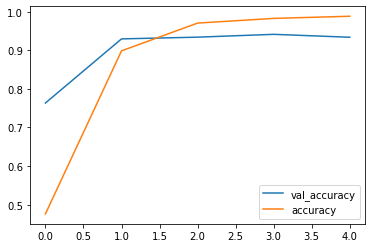

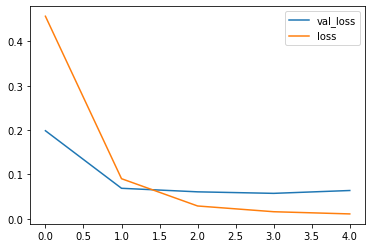

In [22]:
batch_size = 16
epochs = 5

model_bilstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history_bilstm = model_bilstm.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

df = pd.DataFrame(history_bilstm.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [23]:
loss, accuracy = model_bilstm.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

13/13 [==============================] - 1s 99ms/step - loss: 0.0832 - accuracy: 0.9158
Test loss: 0.08321350067853928
Test accuracy: 0.9158333539962769


We are getting better on the test data, what about the confusing sentences?

In [24]:
predictions_bilstm = model_bilstm.predict(strange_sentences_int)
print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions_bilstm))))

[(['Their', 'management', 'plan', 'reforms', 'worked'], ['PRON', 'NOUN', 'NOUN', 'VERB', 'VERB']), (['Attack', 'was', 'their', 'best', 'option'], ['VERB', 'VERB', 'PRON', 'ADJ', 'NOUN'])]


Not so much. We probably need a lot more data to prevent overfitting.

## Sequential API Model

When you google for more details, you might come across the **Sequential API** (because we sequentially add layers, not because this is a sequence model). It does the same thing as the functional API, but in a different way. It is less flexible than the functional API we have been using, though.

In [25]:
from keras.models import Sequential
from keras.layers import InputLayer
np.random.seed(42)

model_seq = Sequential()
model_seq.add(InputLayer(input_shape=(MAX_LENGTH, ), name="word_IDs"))
model_seq.add(Embedding(len(word2int), 128, mask_zero=True, name='embeddings'))
model_seq.add(Bidirectional(LSTM(256, return_sequences=True), name='bi-LSTM'))
model_seq.add(Dropout(0.3, name='dropout'))
model_seq.add(Dense(len(tag2int), name='output'))
model_seq.add(Activation('softmax', name='softmax'))
model_seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 87, 128)           945408    
_________________________________________________________________
bi-LSTM (Bidirectional)      (None, 87, 512)           788480    
_________________________________________________________________
dropout (Dropout)            (None, 87, 512)           0         
_________________________________________________________________
output (Dense)               (None, 87, 13)            6669      
_________________________________________________________________
softmax (Activation)         (None, 87, 13)            0         
Total params: 1,740,557
Trainable params: 1,740,557
Non-trainable params: 0
_________________________________________________________________


In [26]:
batch_size = 32
epochs = 5

model_seq.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model_seq.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/5
51/51 [==============================] - 42s 686ms/step - loss: 0.6257 - accuracy: 0.2856 - val_loss: 0.5156 - val_accuracy: 0.4223
Epoch 2/5
51/51 [==============================] - 37s 722ms/step - loss: 0.4044 - accuracy: 0.5581 - val_loss: 0.1716 - val_accuracy: 0.7988
Epoch 3/5
51/51 [==============================] - 36s 714ms/step - loss: 0.1170 - accuracy: 0.8726 - val_loss: 0.0782 - val_accuracy: 0.9195
Epoch 4/5
51/51 [==============================] - 35s 688ms/step - loss: 0.0372 - accuracy: 0.9650 - val_loss: 0.0673 - val_accuracy: 0.9272
Epoch 5/5
51/51 [==============================] - 45s 878ms/step - loss: 0.0210 - accuracy: 0.9803 - val_loss: 0.0616 - val_accuracy: 0.9341


In [27]:
loss, accuracy = model_seq.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

7/7 [==============================] - 1s 197ms/step - loss: 0.0808 - accuracy: 0.9112
Test loss: 0.08077908307313919
Test accuracy: 0.9112499952316284


The sequential model does have a convenience function, though, `predict_classes()`, which we can use to get the tatg IDs. This changes our inverse transformation a bit, since we no longer need the argmax.

In [28]:
predictions_seq = model_seq.predict_classes(strange_sentences_int)
for sentence, prediction in zip(strange_sentences, predictions_seq):
    pred_ = [int2tag[prediction[i]] for i in range(len(sentence))]
    print(sentence, pred_)


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


['Their', 'management', 'plan', 'reforms', 'worked'] ['PRON', 'NOUN', 'NOUN', 'NOUN', 'VERB']
['Attack', 'was', 'their', 'best', 'option'] ['VERB', 'VERB', 'PRON', 'ADJ', 'NOUN']
